In [1]:
import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNet, SwinUNETR, AHNet, VNet

from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureTyped,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import set_determinism


from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"  # Use the 3rd and 4th GPU. Indexing starts from 0.

# for profiling
import nvtx
from monai.utils.nvtx import Range
import contextlib  # to improve code readability (combining training/validation loop with and without profiling)

#print_config()
set_determinism(0)

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

current_directory = os.getcwd()

out_dir = os.path.join(current_directory,"outputs/")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

root dir is: /tmp/tmp6j1gnjwr


In [6]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from timm.layers.conv2d_same import Conv2dSame

def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional, List


# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1, 1), value: float = 0):
    ih, iw, iz = x.size()[-3:]
    pad_h = get_same_padding(ih, k[0], s[0], d[0])
    pad_w = get_same_padding(iw, k[1], s[1], d[1])
    pad_z = get_same_padding(iz, k[2], s[2], d[2])
    if pad_h > 0 or pad_w > 0 or pad_z > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2, pad_z // 2, pad_z - pad_z // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic


def conv3d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int, int] = (1, 1, 1),
        padding: Tuple[int, int, int] = (0, 0, 0), dilation: Tuple[int, int, int] = (1, 1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-3:], stride, dilation)
    return F.conv3d(x, weight, bias, stride, (0, 0, 0), dilation, groups)


class Conv3dSame(nn.Conv3d):
    """ Tensorflow like 'SAME' convolution wrapper for 3d convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv3dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv3d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv3d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv3dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv3d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1
drop_rate = 0.
drop_path_rate = 0.
out_dim = 6
        
import torch
import torch.nn as nn
import timm
import segmentation_models_pytorch as smp

class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False, num_classes=6):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=0.1,
            drop_path_rate=0.1,
            pretrained=pretrained
        )

        # Modify the first layer of the encoder for 1-channel input
        self.encoder.conv1 = nn.Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)

        self.decoder = smp.Unet(
            encoder_name=backbone,
            encoder_depth=5,
            encoder_weights=None,  # Weights are already loaded in the encoder part
            decoder_use_batchnorm=True,
            decoder_channels=[256, 128, 64, 32, 16],
            decoder_attention_type='scse',
            in_channels=1,
            classes=num_classes,
            activation=None,  # Use 'None' because we handle activation in the loss function (e.g., CrossEntropy)
        )

    def forward(self, x):
        return self.decoder(x)

In [59]:
profiling = True

# to see the trend in training curve and dice results, set max_epochs to be larger (300)
# note that before optimization, training can be quite a bit slower
if profiling:
    max_epochs = 1000
else:
    max_epochs = 400

def range_func(x, y):
    return Range(x)(y) if profiling else y


no_profiling = contextlib.nullcontext()

In [7]:
import os
import pandas as pd
from tqdm import tqdm
from monai.data import Dataset
from torch.utils.data import DataLoader

current_directory = "/workspace/0728tot/ATD/"


split_json = "output_2.json"

datasets = os.path.join(current_directory, split_json)
train_files = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

def transformations(fast=False, device="cuda:0"):
    train_transforms = [
        range_func("LoadImage", LoadImaged(keys=["image", "label"])),
        range_func("EnsureChannelFirst", EnsureChannelFirstd(keys=["image", "label"])),
        range_func("Orientation", Orientationd(keys=["image", "label"], axcodes="RAS")),
        range_func(
            "Spacing",
            Spacingd(
                keys=["image", "label"],
                pixdim=(2.0, 2.0, 2.0),
                mode=("bilinear", "nearest"),
            ),
        ),
        range_func(
            "ScaleIntensityRange",
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
        ),
        #range_func("CropForeground", CropForegroundd(keys=["image", "label"], source_key="image")),
        #range_func("DynamicAxisPad", DynamicAxisPad(keys=['image'], desired_size=96, mode='constant')),
        # range_func(
        #     "Indexing",
        #     FgBgToIndicesd(
        #         keys="label",
        #         fg_postfix="_fg",
        #         bg_postfix="_bg",
        #         image_key="image",
        #     ),
        # ),
    ]

    if fast:
        # convert the data to Tensor without meta, move to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            range_func("EnsureType", EnsureTyped(keys=["image", "label"], device=device, track_meta=False))
        )

    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        range_func(
            "RandCrop",
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=3,
                fg_indices_key="label_fg",
                bg_indices_key="label_bg",
            ),
        ),
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(2.0, 2.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
    if fast:
        # convert the data to Tensor without meta, move to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(EnsureTyped(keys=["image", "label"], device=device, track_meta=False))

    return Compose(train_transforms), Compose(val_transforms)

In [62]:
def train_process(fast=False):
    learning_rate = 2e-4
    val_interval = 5  # do validation for every epoch
    set_track_meta(True)

    if torch.cuda.is_available():
        data_device = torch.device("cuda:0")
    else:
        raise RuntimeError("this tutorial is intended for GPU, but no CUDA device is available")

    train_trans, val_trans = transformations(fast=fast, device=data_device)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        # as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
        # the crop area instead of modifying the cached value, we can set `copy_cache=False`
        # to avoid unnecessary deepcopy of cached content in `CacheDataset`
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
            copy_cache=False,
        )
        val_ds = CacheDataset(data=val_files, transform=val_trans,cache_rate=1.0, num_workers=5, copy_cache=False)
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)
        
        model_device = torch.device("cuda:1")
        
        loss_function = DiceCELoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            squared_pred=True,
            batch=True,
            smooth_nr=0.00001,
            smooth_dr=0.00001,
            lambda_dice=0.5,
            lambda_ce=0.5,
        )
        # Create the model
        model = TimmSegModel(backbone = 'resnet18', segtype='unet', pretrained = True)
        model = convert_3d(model)
        # Test the model (just to ensure everything is working)
        model = model.to(model_device)
        # model = UNet(
        #     spatial_dims=3,
        #     in_channels=1,
        #     out_channels=6,
        #     channels=(32, 64, 128, 256, 512),
        #     strides=(2, 2, 2, 2),
        #     num_res_units=2,
        #     norm=Norm.BATCH,
        #     kernel_size=3,
        #     up_kernel_size=3,
        #     act=Act.PRELU,
        #     dropout=0.2,
        #     bias=True,
        # ).to(model_device)

        # avoid the computation of meta information in random transforms
        set_track_meta(False)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=6,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(model_device)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=6)])
    post_label = Compose([AsDiscrete(to_onehot=6)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    if fast:
        # SGD prefer to much bigger learning rate
        optimizer = SGD(
            model.parameters(),
            lr=learning_rate * 1000,
            momentum=0.9,
            weight_decay=0.00004,
        )
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()

    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # profiling: full epoch
        with nvtx.annotate("epoch", color="red") if profiling else no_profiling:
            model.train()
            epoch_loss = 0
            train_loader_iterator = iter(train_loader)

            # using step instead of iterate through train_loader directly to track data loading time
            # steps are 1-indexed for printing and calculation purposes
            for step in range(1, len(train_loader) + 1):
                step_start = time.time()

                # profiling: train dataload
                with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                    # rng_train_dataload = nvtx.start_range(message="dataload", color="red")
                    batch_data = next(train_loader_iterator)
                    inputs, labels = (
                        batch_data["image"].to(model_device),
                        batch_data["label"].to(model_device),
                    )

                optimizer.zero_grad()
                # set AMP for MONAI training
                if fast:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        scaler.scale(loss).backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        scaler.step(optimizer)
                        scaler.update()
                else:
                    # profiling: forward
                    with nvtx.annotate("forward", color="green") if profiling else no_profiling:
                        outputs = model(inputs)
                        loss = loss_function(outputs, labels)

                    # profiling: backward
                    with nvtx.annotate("backward", color="blue") if profiling else no_profiling:
                        loss.backward()

                    # profiling: update
                    with nvtx.annotate("update", color="yellow") if profiling else no_profiling:
                        optimizer.step()

                epoch_loss += loss.item()
                epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
                print(
                    f"{step}/{epoch_len}, train_loss: {loss.item():.4f}" f" step time: {(time.time() - step_start):.4f}"
                )
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                with torch.no_grad():
                    val_loader_iterator = iter(val_loader)

                    for _ in range(len(val_loader)):
                        # profiling: val dataload
                        with nvtx.annotate("dataload", color="red") if profiling else no_profiling:
                            val_data = next(val_loader_iterator)
                            val_inputs, val_labels = (
                                val_data["image"].to(model_device),
                                val_data["label"].to(model_device),
                            )

                        roi_size = (96, 96, 96)
                        sw_batch_size = 4

                        # profiling: sliding window
                        with nvtx.annotate("sliding window", color="green") if profiling else no_profiling:
                            # set AMP for MONAI validation
                            if fast:
                                with torch.cuda.amp.autocast():
                                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                            else:
                                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                        # profiling: decollate batch
                        with nvtx.annotate("decollate batch", color="blue") if profiling else no_profiling:
                            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                            val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                        # profiling: compute metric
                        with nvtx.annotate("compute metric", color="yellow") if profiling else no_profiling:
                            dice_metric(y_pred=val_outputs, y=val_labels)

                    metric = dice_metric.aggregate().item()
                    dice_metric.reset()
                    metric_values.append(metric)
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        best_metrics_epochs_and_time[0].append(best_metric)
                        best_metrics_epochs_and_time[1].append(best_metric_epoch)
                        best_metrics_epochs_and_time[2].append(time.time() - total_start)
                        torch.save(model.state_dict(), os.path.join(current_directory, "resnet18_unet_best_metric_model.pt"))
                        print("saved new best metric model")
                    print(
                        f"current epoch: {epoch + 1} current"
                        f" mean dice: {metric:.4f}"
                        f" best mean dice: {best_metric:.4f}"
                        f" at epoch: {best_metric_epoch}"
                    )
        print(f"time consuming of epoch {epoch + 1} is:" f" {(time.time() - epoch_start):.4f}")
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

In [63]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
Loading dataset: 100%|███████████████████████████████████| 12/12 [00:40<00:00,  3.36s/it]


----------
epoch 1/1000
1/11, train_loss: 1.8430 step time: 1.4230
2/11, train_loss: 0.9391 step time: 0.4152
3/11, train_loss: 0.9081 step time: 0.4137
4/11, train_loss: 0.6813 step time: 0.4180
5/11, train_loss: 0.7397 step time: 0.4588
6/11, train_loss: 0.8783 step time: 0.4792
7/11, train_loss: 0.7454 step time: 0.4678
8/11, train_loss: 0.8256 step time: 0.4896
9/11, train_loss: 0.6742 step time: 0.4783
10/11, train_loss: 0.6977 step time: 0.4595
11/11, train_loss: 0.6882 step time: 0.2850
epoch 1 average loss: 0.8746
time consuming of epoch 1 is: 5.7905
----------
epoch 2/1000
1/11, train_loss: 0.6604 step time: 0.4901
2/11, train_loss: 0.7700 step time: 0.4754
3/11, train_loss: 0.6420 step time: 0.4753
4/11, train_loss: 0.6837 step time: 0.5267
5/11, train_loss: 0.6696 step time: 0.4801
6/11, train_loss: 0.7027 step time: 0.4949
7/11, train_loss: 0.6635 step time: 0.4844
8/11, train_loss: 0.6359 step time: 0.4721
9/11, train_loss: 0.6300 step time: 0.4394
10/11, train_loss: 0.601

In [9]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)

In [10]:
test_files = load_decathlon_datalist(datasets, True, "test")

In [11]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(2.0, 2.0, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.


In [8]:
model_device = torch.device("cuda:1") 

# Create the model
model = TimmSegModel(backbone = 'resnet18', segtype='unet', pretrained = True)
model = convert_3d(model)
# Test the model (just to ensure everything is working)
model = model.to(model_device)

model.load_state_dict(torch.load(os.path.join(current_directory, "resnet18_unet_best_metric_model.pt")))
model.eval()


TimmSegModel(
  (encoder): FeatureListNet(
    (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_s

In [12]:
curr_data = None
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(model_device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        curr_data =  sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        break

In [11]:
ideal_size = list(test_data['image_meta_dict']['spatial_shape'][0].cpu().detach().numpy())

In [52]:
import torch.nn.functional as F

# Move curr_data to CPU
segmented = curr_data.cpu()

# Merge the masks with numbers (1 to 6)
merged = torch.argmax(segmented, dim=1) + 1  # add 1 to move the range from 0-5 to 1-6

# Ensure background remains 0
#merged[segmented.sum(dim=1) == 0] = 0


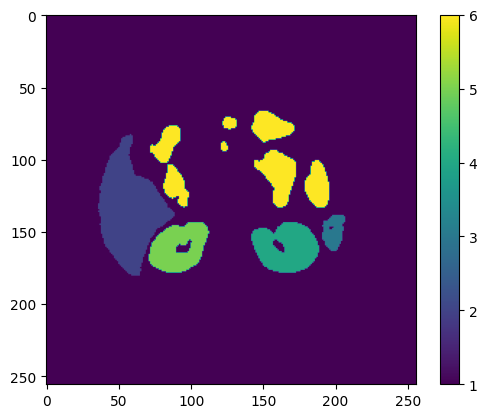

In [65]:
plt.imshow(merged[0][120])
plt.colorbar()